In [1]:
# Standard
import datetime
import os
import random
import re
from pathlib import Path

# Third-party
import numpy as np
from scipy.stats import uniform

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
)

import bayesflow as bf
import keras
from bayesflow.simulators import LambdaSimulator


# Global reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

2025-07-14 17:48:40.185385: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-14 17:48:40.198518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752508120.213150  607897 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752508120.217703  607897 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752508120.230495  607897 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Directories setup
batch_size = 64
simulation_version = "LIFv1"
initial_learning_rate = 1e-3
time_stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
run_id = f"{simulation_version}_lr{initial_learning_rate}_bs{batch_size}_{time_stamp}"

root_dir = Path("results") / run_id
plot_dir = root_dir / "plots"
diag_dir = root_dir / "diagnostics"
ckpt_dir = root_dir / "checkpoints"

for d in (plot_dir, diag_dir, ckpt_dir):
    d.mkdir(parents=True, exist_ok=True)

print("Saving everything under", root_dir)


vis_dir = Path("results") / run_id / "plots" / "visualise"
vis_dir.mkdir(parents=True, exist_ok=True)

Saving everything under results/LIFv1_lr0.001_bs64_20250714-174841


In [3]:
# 1. Biophysical priors
PRIOR = dict(
    Cm=(100e-12, 200e-12),  # 100–200 pF
    g_L=(5e-9, 15e-9),  # 5–15  nS
    E_L=(-80e-3, -65e-3),  # –80 to –65 mV
    V_th=(-60e-3, -50e-3),  # –60 to –50 mV
    V_res=(-80e-3, -70e-3),  # up to 10 mV below rest
    t_ref=(1e-3, 5e-3),  # 1–5  ms
)
PRIOR_KEYS = list(PRIOR)


def sample_prior(n, rng=None):
    """
    Draw n parameter vectors from the biophysical priors *and*
    make sure they satisfy V_res < E_L < V_th **while staying inside
    the original support of each uniform prior**.
    """
    rng = np.random.default_rng() if rng is None else rng

    # 1) Independent uniform draws
    pars = np.column_stack([rng.uniform(lo, hi, size=n) for lo, hi in PRIOR.values()])

    # 2) Ordering constraints
    Vres, EL, Vth = [PRIOR_KEYS.index(k) for k in ("V_res", "E_L", "V_th")]

    bad = pars[:, Vres] >= pars[:, EL]
    pars[bad, Vres] = pars[bad, EL] - 2e-3
    
    # Keep inside original V_res interval
    pars[bad, Vres] = np.clip(
        pars[bad, Vres], PRIOR["V_res"][0], PRIOR["V_res"][1]
    )

    bad = pars[:, EL] >= pars[:, Vth]  # E_L not below V_th
    pars[bad, EL] = pars[bad, Vth] - 5e-3
    
    # keep inside original E_L interval
    pars[bad, EL] = np.clip(pars[bad, EL], PRIOR["E_L"][0], PRIOR["E_L"][1])

    return pars.astype(np.float32)


# 2. Core single-neuron integrator
def lif_integrate(T, dt, p, I):
    Cm, gL, EL, Vth, Vres, tref = p
    n = int(np.round(T / dt)) + 1
    t = np.linspace(0, T, n, dtype=np.float32)
    if np.isscalar(I):
        I = np.full(n, I, dtype=np.float32)
    elif I.shape[0] != n:
        raise ValueError("current length mismatch")
    V = np.full(n, EL, dtype=np.float32)
    spikes = []
    tau_m = Cm / gL
    R_m = 1.0 / gL
    last_s = -np.inf
    for i in range(1, n):
        if t[i] - last_s < tref:
            V[i] = Vres
            continue
        dV = (-(V[i - 1] - EL) + R_m * I[i - 1]) * dt / tau_m
        V[i] = V[i - 1] + dV
        if V[i] >= Vth:
            V[i] = Vres
            last_s = t[i]
            spikes.append(t[i])
    return V


def coloured_current(t, base_amp, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    white = rng.standard_normal(t.size)
    tau = 0.01
    kern = np.exp(-np.arange(t.size) * t[1] / tau)
    coloured = np.convolve(white, kern, mode="same")
    coloured /= np.max(np.abs(coloured)) + 1e-9
    return base_amp * (1 + 0.25 * np.sin(2 * np.pi * 10 * t) + 0.15 * coloured)


# 4. Generate dataset
def build_dataset(N=10_000, *, T=0.05, dt=1e-4, rng=None):
    """
    Parameters
    ----------
    N   : int        total number of simulated traces
    T   : float      simulation window (seconds)
    dt  : float      time step (seconds)
    rng : np.random.Generator or None
    """
    rng = np.random.default_rng() if rng is None else rng
    theta = sample_prior(N, rng=rng)
    nstep = int(np.round(T / dt)) + 1
    t_vect = np.linspace(0, T, nstep, dtype=np.float32)

    traces = np.zeros((N, nstep, 1), dtype=np.float32)
    for i, p in enumerate(theta):
        amp = rng.uniform(0.3e-9, 3e-9)
        I = coloured_current(t_vect, amp, rng=rng)
        traces[i, :, 0] = lif_integrate(T, dt, p, I)

    return theta, traces, t_vect


rng = np.random.default_rng(SEED)
N_TOTAL = 10_000
theta, traces, t_vec = build_dataset(N_TOTAL, rng=rng)
print(theta.shape, traces.shape)


idx = rng.permutation(len(theta))
train_idx, val_idx = idx[:8000], idx[8000:]

train_data = {"parameters": theta[train_idx], "observables": traces[train_idx]}
val_data = {"parameters": theta[val_idx], "observables": traces[val_idx]}

(10000, 6) (10000, 501, 1)


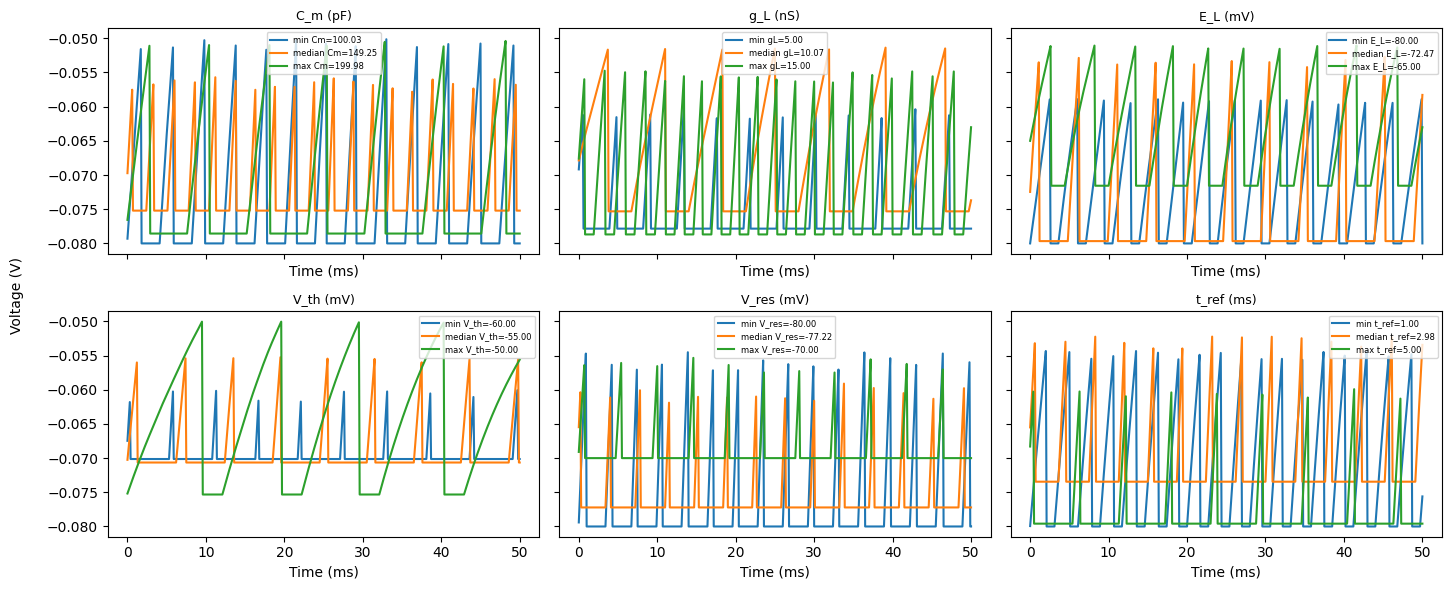

✔ overview saved → results/LIFv1_lr0.001_bs64_20250714-174841/plots/min_med_max/min_med_max_overview.png
  • Cm_min_med_max.png saved
  • gL_min_med_max.png saved
  • E_L_min_med_max.png saved
  • V_th_min_med_max.png saved
  • V_res_min_med_max.png saved
  • t_ref_min_med_max.png saved


In [4]:
def plot_min_med_max(
    theta, traces, t, *, subset=6_000, run_id="unnamed_run", root="results"
):
    """
    Draw and SAVE:
      • overview figure (6 sub-plots)
      • one panel per parameter

    Saves into:   results/<run_id>/plots/min_med_max/
    """
    
    save_dir = Path(root) / run_id / "plots" / "min_med_max"
    save_dir.mkdir(parents=True, exist_ok=True)

    # Data preparation
    take = slice(0, min(subset, len(theta)))
    theta_ = theta[take]
    tr_ = traces[take, :, 0]

    names = [
        "C_m (pF)",
        "g_L (nS)",
        "E_L (mV)",
        "V_th (mV)",
        "V_res (mV)",
        "t_ref (ms)",
    ]
    short = ["Cm", "gL", "E_L", "V_th", "V_res", "t_ref"]
    scales = [1e12, 1e9, 1e3, 1e3, 1e3, 1e3]

    # Overview figure
    fig, axs = plt.subplots(2, 3, figsize=(15, 6), sharex=True, sharey=True)
    axs = axs.ravel()

    for j, ax in enumerate(axs):
        sort_idx = np.argsort(theta_[:, j])
        sel = sort_idx[[0, len(sort_idx) // 2, -1]]
        lbls = ["min", "median", "max"]

        for k, idx in enumerate(sel):
            val = theta_[idx, j] * scales[j]
            ax.plot(t * 1e3, tr_[idx], label=f"{lbls[k]} {short[j]}={val:.2f}")
        ax.set_title(names[j], fontsize=9)
        ax.set_xlabel("Time (ms)")
        ax.legend(fontsize=6)

    fig.text(0.04, 0.5, "Voltage (V)", rotation="vertical", ha="center", va="center")
    fig.tight_layout(rect=[0.05, 0, 1, 1])
    plt.show()

    # save overview
    overview_path = save_dir / "min_med_max_overview.png"
    fig.savefig(overview_path, dpi=300)
    print("✔ overview saved →", overview_path)

    # individual panels
    for j in range(6):
        f, ax = plt.subplots(figsize=(4, 3))
        sort_idx = np.argsort(theta_[:, j])
        sel = sort_idx[[0, len(sort_idx) // 2, -1]]
        lbls = ["min", "median", "max"]

        for k, idx in enumerate(sel):
            val = theta_[idx, j] * scales[j]
            ax.plot(t * 1e3, tr_[idx], label=f"{lbls[k]} {short[j]}={val:.2f}")
        ax.set_title(names[j])
        ax.set_xlabel("Time (ms)")
        ax.set_ylabel("Voltage (V)")
        ax.legend(fontsize=7)
        f.tight_layout()

        indiv_path = save_dir / f"{short[j]}_min_med_max.png"
        f.savefig(indiv_path, dpi=300)
        plt.close(f)
        print("  •", indiv_path.name, "saved")

    plt.close(fig)


plot_min_med_max(
    theta, traces, t_vec, subset=6_000, run_id=run_id
)

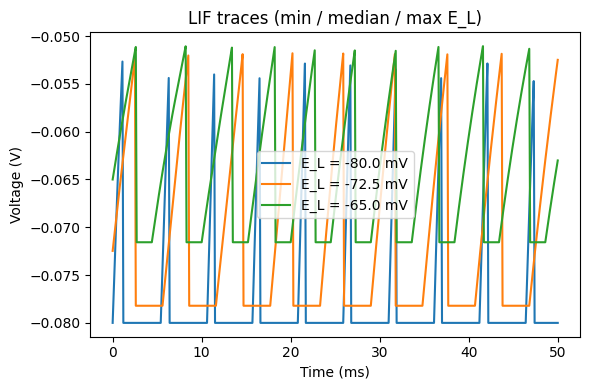

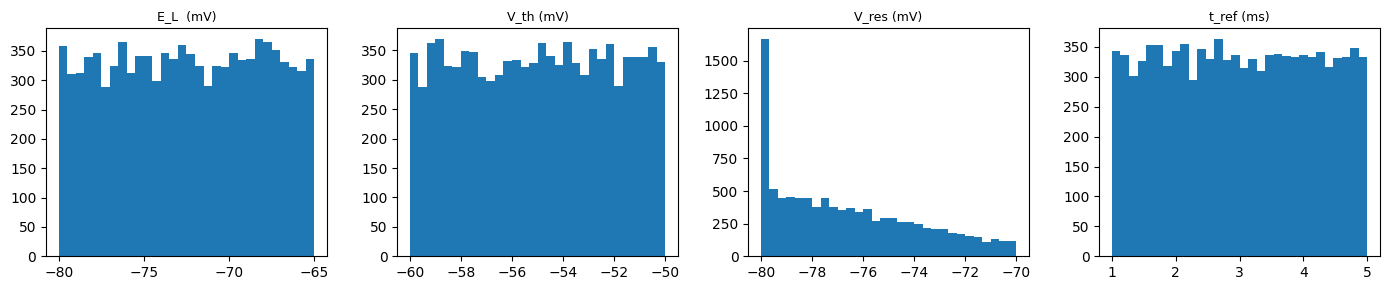

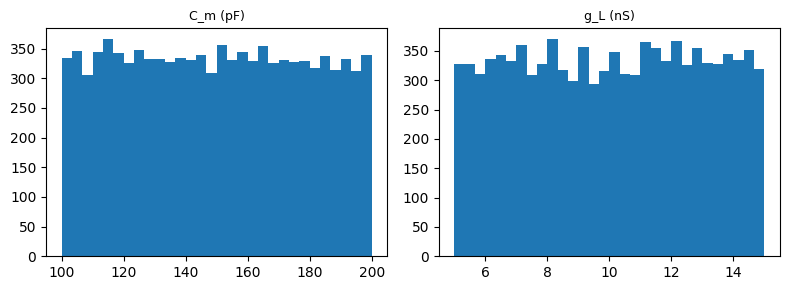

✔ all visualisation PNGs saved in  results/LIFv1_lr0.001_bs64_20250714-174841/plots/visualise


In [5]:
# 4. Visualise

# 4.1 Line traces for min / median / max E_L
eL_col = PRIOR_KEYS.index("E_L")
sort_idx = np.argsort(theta[:, eL_col])
select = sort_idx[[0, len(sort_idx) // 2, -1]]

fig, ax = plt.subplots(figsize=(6, 4))
for k in select:
    E_val = theta[k, eL_col] * 1e3  # → mV
    ax.plot(t_vec * 1e3, traces[k, :, 0], label=f"E_L = {E_val:.1f} mV")
ax.set_title("LIF traces (min / median / max E_L)")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Voltage (V)")
ax.legend()
fig.tight_layout()
fig.savefig(vis_dir / "EL_min_med_max_traces.png", dpi=300)
plt.show()

# 4.2 Histograms: E_L, V_th, V_res, t_ref
names_units = [
    ("E_L  (mV)", 1e3),
    ("V_th (mV)", 1e3),
    ("V_res (mV)", 1e3),
    ("t_ref (ms)", 1e3),
]
fig, axs = plt.subplots(1, 4, figsize=(14, 3))
for ax, (par_name, scale), key in zip(
    axs, names_units, ["E_L", "V_th", "V_res", "t_ref"]
):
    j = PRIOR_KEYS.index(key)
    ax.hist(theta[:, j] * scale, bins=30)
    ax.set_title(par_name, fontsize=9)
fig.tight_layout()
fig.savefig(vis_dir / "hist_voltage_params_overview.png", dpi=300)
plt.show()

# 4.3.a Save each of the 4 histograms separately
for (par_name, scale), key in zip(names_units, ["E_L", "V_th", "V_res", "t_ref"]):
    j = PRIOR_KEYS.index(key)
    f, ax = plt.subplots(figsize=(3, 3))
    ax.hist(theta[:, j] * scale, bins=30)
    ax.set_title(par_name)
    f.tight_layout()
    short = key.replace("_", "")
    f.savefig(vis_dir / f"hist_{short}.png", dpi=300)
    plt.close(f)

# 4.3.b  Histograms: Cm, g_L
names_units_2 = [("C_m (pF)", 1e12), ("g_L (nS)", 1e9)]
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
for ax, (par_name, scale), key in zip(axs, names_units_2, ["Cm", "g_L"]):
    j = PRIOR_KEYS.index(key)
    ax.hist(theta[:, j] * scale, bins=30)
    ax.set_title(par_name, fontsize=9)
fig.tight_layout()
fig.savefig(vis_dir / "hist_passive_params_overview.png", dpi=300)
plt.show()

# 4.3.c Save each of the 2 histograms separately
for (par_name, scale), key in zip(names_units_2, ["Cm", "g_L"]):
    j = PRIOR_KEYS.index(key)
    f, ax = plt.subplots(figsize=(3, 3))
    ax.hist(theta[:, j] * scale, bins=30)
    ax.set_title(par_name)
    f.tight_layout()
    f.savefig(vis_dir / f"hist_{key}.png", dpi=300)
    plt.close(f)

print(f"✔ all visualisation PNGs saved in  {vis_dir}")

In [6]:
# 5. Batched simulator wrapper for BayesFlow
def batch_simulator(batch_params):
    """BayesFlow expects .sample(batch_shape) → dict."""
    bs = batch_params.shape[0]
    T, dt = 0.05, 1e-4
    nstep = int(np.round(T / dt)) + 1
    t = np.linspace(0, T, nstep, dtype=np.float32)
    traces = np.zeros((bs, nstep, 1), dtype=np.float32)
    for i, p in enumerate(batch_params):
        amp = np.random.uniform(0.3e-9, 3e-9)
        I = coloured_current(t, amp)
        traces[i, :, 0] = lif_integrate(T, dt, p, I)
    return {"parameters": batch_params.astype(np.float32), "observables": traces}


simulator = LambdaSimulator(batch_simulator, is_batched=True)

adapter = (
    bf.Adapter()
    .convert_dtype("float64", "float32")
    .standardize(include=["parameters", "observables"])
    .concatenate(["parameters"], into="inference_variables")
    .rename("observables", "summary_variables")
)

workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=bf.networks.CouplingFlow(),  # default Configuration Network Flow
    summary_network=bf.networks.TimeSeriesNetwork(),  # Convolution + GRU
    inference_variables=["parameters"],
    summary_variables=["observables"],
    initial_learning_rate=initial_learning_rate,
    optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),
)

In [7]:
# 7. Training
ckpt_cb = ModelCheckpoint(
    filepath=os.path.join(
        ckpt_dir, run_id + "_epoch{epoch:02d}_vl{val_loss:.4f}.keras"
    ),
    monitor="val_loss",
    mode="min",  # "auto" Keras infers the right direction from the metric’s name
    save_best_only=True,  # keep only the best epoch
    save_weights_only=False,  # save the full model (weights+architecture)
    verbose=1,
)

early_cb = EarlyStopping(
    monitor="val_loss", patience=12, restore_best_weights=True, verbose=1
)

lr_cb = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=6, min_lr=1e-6, verbose=1
)

history = workflow.fit_offline(
    data=train_data,
    epochs=100,
    batch_size=batch_size,
    validation_data=val_data,
    callbacks=[ckpt_cb, early_cb, lr_cb],
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.
/home/rajubuntu/Study/TU Dortmund/Simulation-based Inference/Project/repo/simulation-based-inference/.venv/lib/python3.12/site-packages/bayesflow/adapters/transforms/standardize.py:74: FutureWarning: Dynamic standardization is deprecated and will be removed in later versions.Instead, use the standardize argument of the approximator / workflow instance or provide fixed mean and std arguments. You may incur some redundant computations if you keep this transform.
  warnings.warn(
I0000 00:00:1752508131.727874  607897 cuda_dnn.cc:529] Loaded cuDNN version 90300


Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 5.4754
Epoch 1: val_loss improved from inf to 3.07930, saving model to results/LIFv1_lr0.001_bs64_20250714-174841/checkpoints/LIFv1_lr0.001_bs64_20250714-174841_epoch01_vl3.0793.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 94ms/step - loss: 5.4754 - val_loss: 3.0793 - learning_rate: 0.0010
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 2.8399
Epoch 2: val_loss improved from 3.07930 to 1.63099, saving model to results/LIFv1_lr0.001_bs64_20250714-174841/checkpoints/LIFv1_lr0.001_bs64_20250714-174841_epoch02_vl1.6310.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - loss: 2.8399 - val_loss: 1.6310 - learning_rate: 0.0010
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 1.4473
Epoch 3: val_loss improved from 1.63099 to 0.26826, saving model to results/LIFv1_lr0.001_bs64_20250714-174841/checkpoints/LIFv1_lr0.001_bs64_20250714-174841_epoch03_vl0.2683.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 1

{'losses': <Figure size 1600x400 with 1 Axes>,
 'recovery': <Figure size 3000x500 with 6 Axes>,
 'calibration_ecdf': <Figure size 3000x500 with 6 Axes>,
 'z_score_contraction': <Figure size 3000x500 with 6 Axes>}

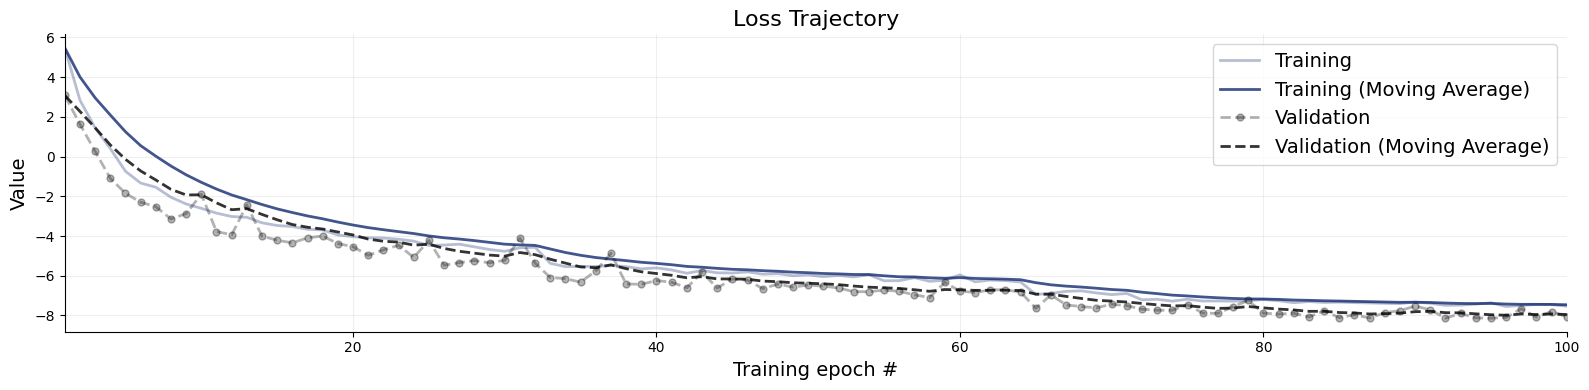

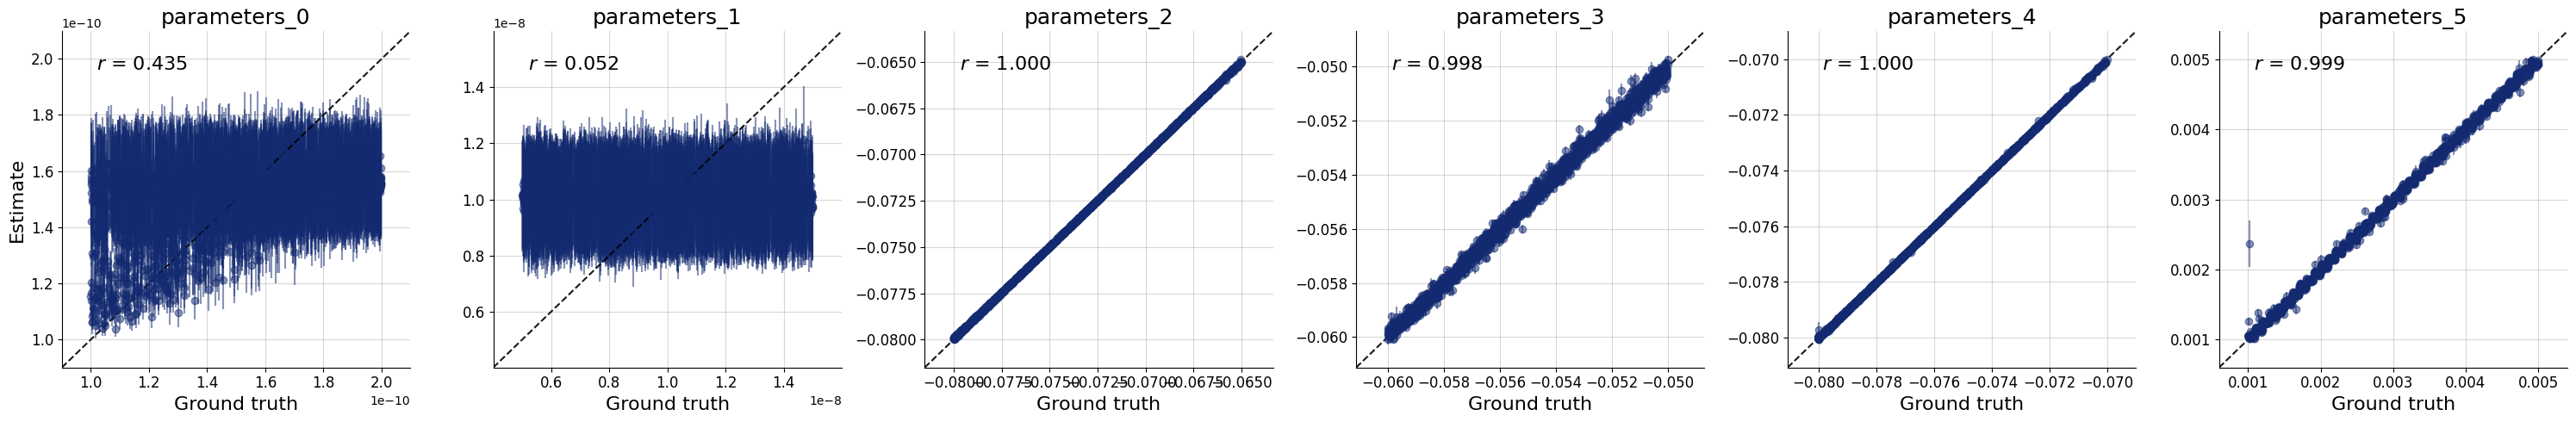

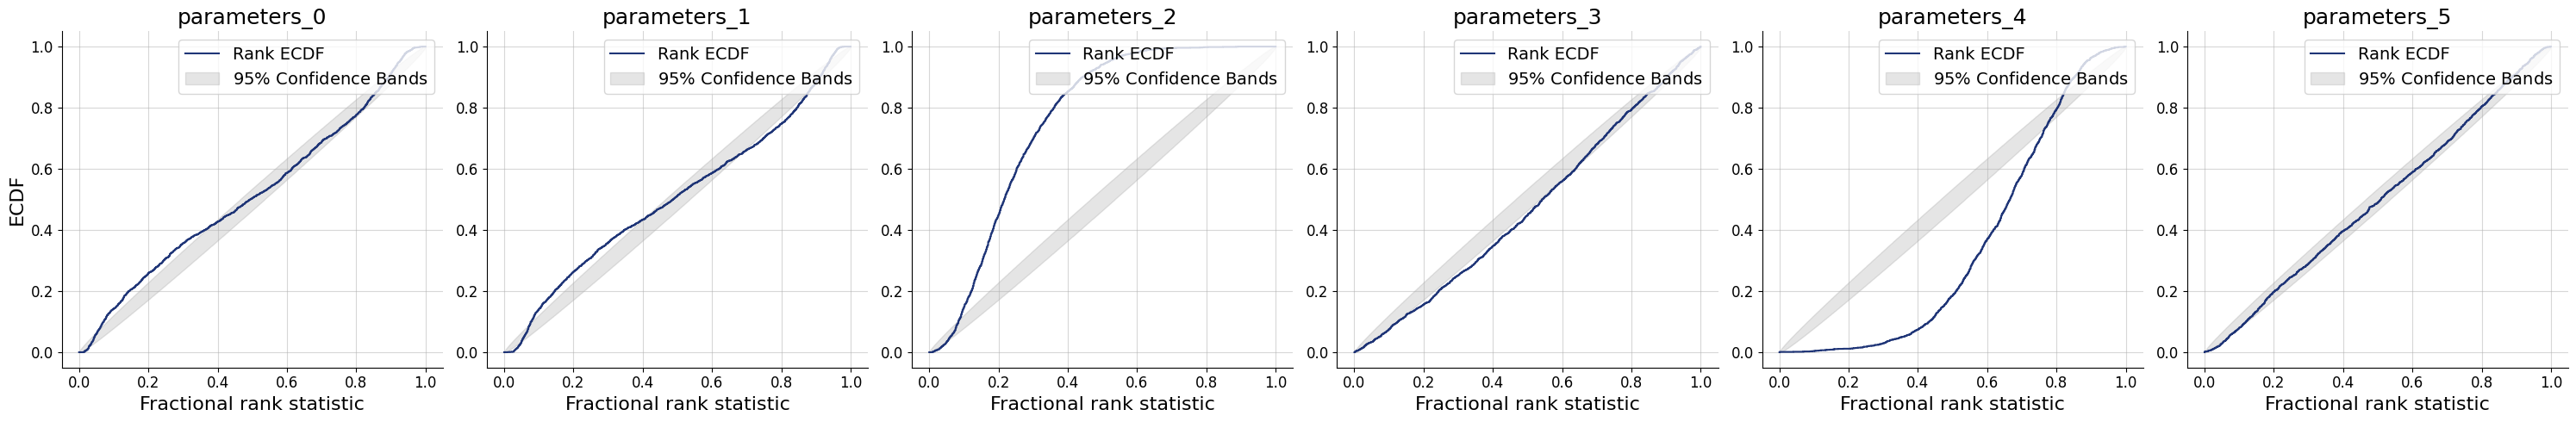

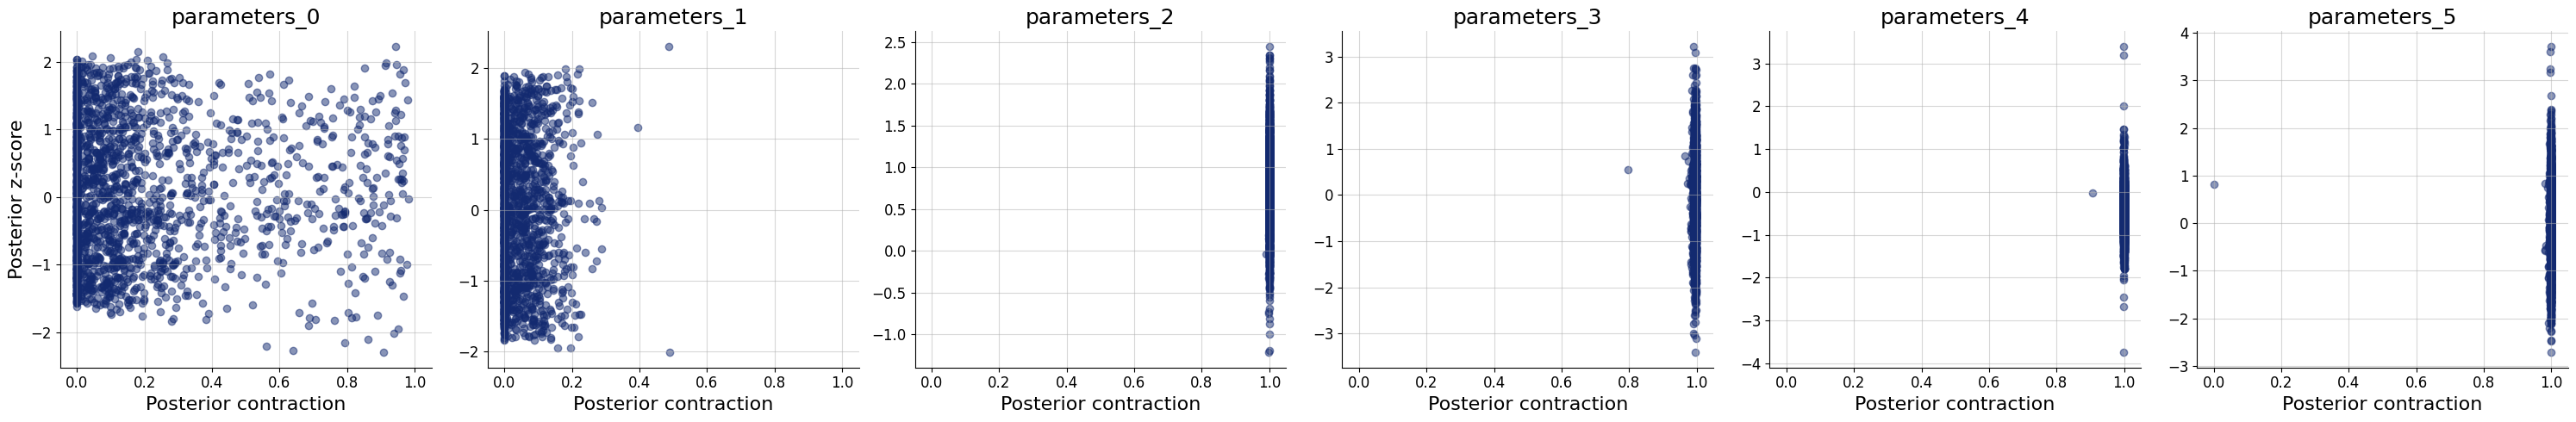

In [8]:
# 8. Diagnostics
workflow.plot_default_diagnostics(test_data=val_data, num_samples=500)

In [9]:
# Save the 3 default BayesFlow diagnostics as individual images
# 1. run BayesFlow’s helper – it returns a dict of figures
fig_dict = workflow.plot_default_diagnostics(test_data=val_data, num_samples=500)

out_dir = Path("bayesflow_diagnostics")
out_dir.mkdir(exist_ok=True)

# 3. iterate over the dict and save each figure
for name, fig in fig_dict.items():
    png_path = out_dir / f"{name}.png"
    fig.savefig(png_path, dpi=300, bbox_inches="tight")
    print(f"saved → {png_path}")

plt.close("all")

saved → bayesflow_diagnostics/losses.png
saved → bayesflow_diagnostics/recovery.png
saved → bayesflow_diagnostics/calibration_ecdf.png
saved → bayesflow_diagnostics/z_score_contraction.png


Loading LIFv1_lr0.001_bs64_20250714-174841_epoch95_vl-8.1362.keras
saved → results/LIFv1_lr0.001_bs64_20250714-174841/plots/param_recovery_scatter.png


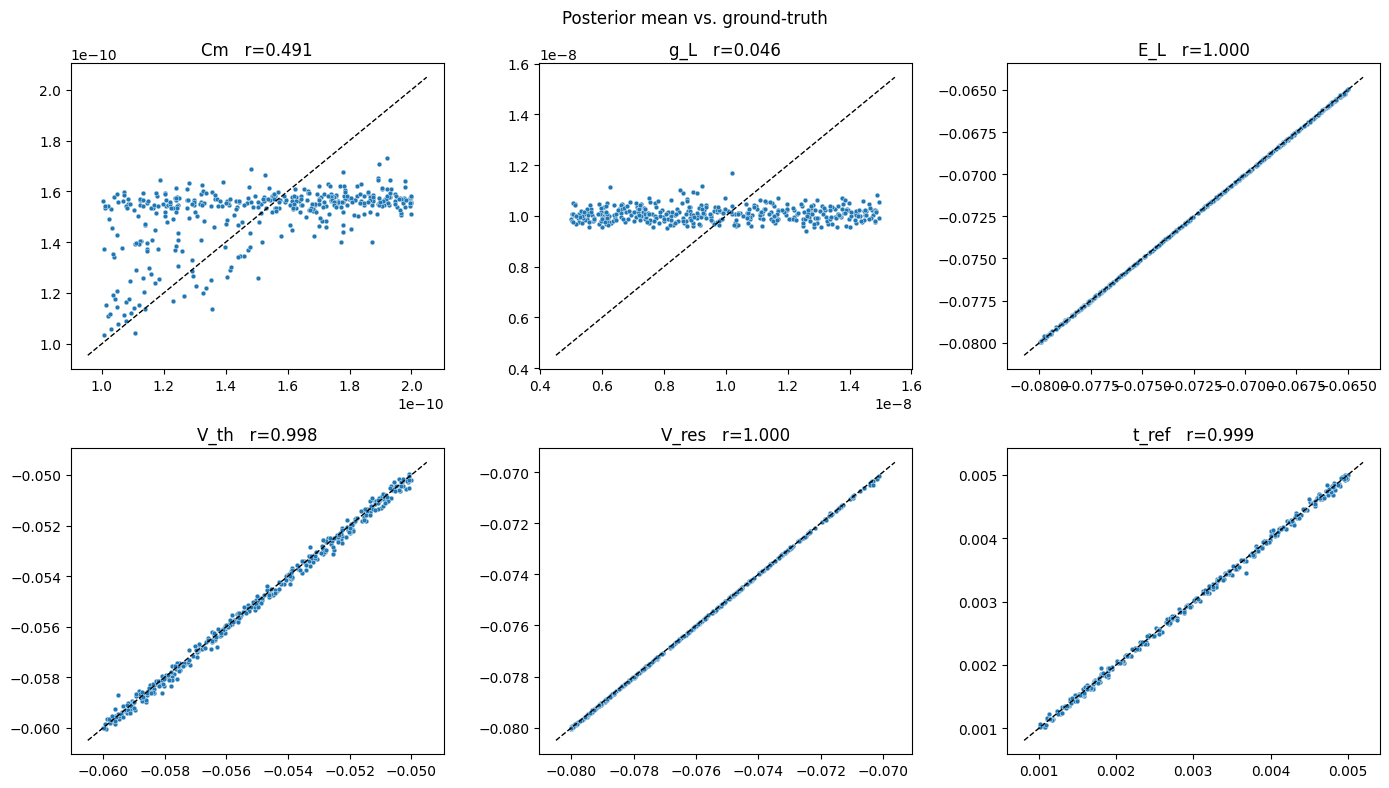

saved → results/LIFv1_lr0.001_bs64_20250714-174841/plots/ppc_random_trace.png


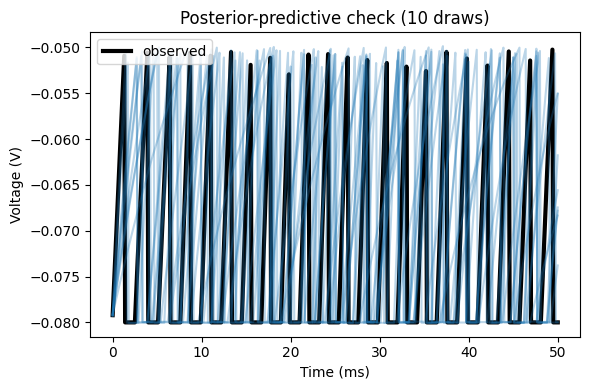

In [10]:
# 1. Load the best model from training
def extract_vloss(path: Path) -> float:
    """Parse the val-loss that appears after '_vl' in the filename."""
    m = re.search(r"_vl([-+]?\d*\.\d+|\d+)", path.name)
    return float(m.group(1)) if m else float("inf")


# pattern that matches your run's checkpoints
pattern = f"{run_id}_epoch*_vl*.keras"

# Path.glob returns Path objects → we can take min() with the helper above
best_path = min(ckpt_dir.glob(pattern), key=extract_vloss)

print("Loading", best_path.name)
approximator = keras.models.load_model(best_path)

# 2. Fresh test set (250 traces never seen in training)
n_test = 400
theta_true, x_true, t_axis = build_dataset(n_test)  # t_axis has length 501

# 3. Posterior sampling  (S = 500 per observation)
S = 1000
posts = approximator.sample(
    conditions={"observables": x_true.astype("float32")},  # key matches adapter
    num_samples=S,  # BayesFlow ≥ 2 arg name
)

# posterior draws  →  dict  {"parameters": (N , S , 6)}
param_samples = posts["parameters"]  # shape (250 , 500 , 6)

# posterior means
post_mean = param_samples.mean(axis=1)  # (250 , 6)

# 4 Parameter-recovery scatter + Pearson r
param_names = ["Cm", "g_L", "E_L", "V_th", "V_res", "t_ref"]

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.ravel()
for j, ax in enumerate(axes):
    sns.scatterplot(x=theta_true[:, j], y=post_mean[:, j], ax=ax, s=12)
    r = np.corrcoef(theta_true[:, j], post_mean[:, j])[0, 1]
    ax.set_title(f"{param_names[j]}   r={r:.3f}")
    ax.plot(ax.get_xlim(), ax.get_xlim(), "k--", lw=1)
plt.suptitle("Posterior mean vs. ground-truth")
plt.tight_layout()

png_path = f"results/{run_id}/plots/param_recovery_scatter.png"
plt.savefig(png_path, dpi=300)
print(f"saved → {png_path}")
plt.show()

# 5 Posterior-predictive check on one random test trace
idx = np.random.randint(n_test)
x_obs = x_true[idx, :, 0]
post_s = param_samples[idx]

T, dt = 0.05, 1e-4
t_axis = np.linspace(0, T, x_obs.shape[0])

n_ppc = 10
pp_tr = np.zeros((n_ppc, x_obs.shape[0]))
for k in range(n_ppc):
    p = post_s[np.random.randint(S)]
    amp = np.random.uniform(0.3e-9, 3e-9)
    I = coloured_current(t_axis, amp)
    pp_tr[k] = lif_integrate(T, dt, p, I)

plt.figure(figsize=(6, 4))
plt.plot(t_axis * 1e3, x_obs, lw=3, color="black", label="observed")
for k in range(n_ppc):
    plt.plot(t_axis * 1e3, pp_tr[k], alpha=0.3, color="tab:blue")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (V)")
plt.title(f"Posterior-predictive check ({n_ppc} draws)")
plt.legend()
plt.tight_layout()

png_path = f"results/{run_id}/plots/ppc_random_trace.png"
plt.savefig(png_path, dpi=300)
print(f"saved → {png_path}")
plt.show()